## I O T S Z J L

In [1]:
import logging 
from tetris import TetrisGame
from copy import deepcopy
# 配置日志记录器
def setup_logger(log_file='game.log', level=logging.INFO):
    logger = logging.getLogger('tetris')
    logger.setLevel(level)
    
    # 创建文件处理器
    file_handler = logging.FileHandler(log_file)
    file_handler.setLevel(level)
    
    # 创建格式化器
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    
    # 添加处理器到日志记录器
    logger.addHandler(file_handler)
    
    return logger
logger = setup_logger()

In [2]:
import numpy as np
from display import *
    
# testgame = TetrisGame()
# tick=0
# handle = DisplayHandle()
# display(handle)
# # 可能的动作: 0-下落一格, 1-左移, 2-右移, 3-旋转, 4-快速下落
# actions = [0, 1, 2, 3, 4]
# # 动作权重分配 - 增加普通下落和旋转的概率
# weights = [0.4, 0.2, 0.2, 0.15, 0.05]

# while not getattr(testgame, 'game_over', False):
#     render_ascii(handle,testgame)
#     testgame.step(0)   # 让方块一步下落
#     tick+=1
#     if tick % 3 == 0:
#         # 随机选择一个动作
#         action = random.choices(actions, weights=weights)[0]
#         testgame.step(action)
#         render_ascii(handle,testgame)
#     time.sleep(0.3)
# # 尾帧显示控制
# # 首行落锁方块为0，说明是下一个方块下落导致挂的
# if not testgame.board[0,:].any():
#     render_ascii(handle,testgame)

In [3]:
from numpy.lib.stride_tricks import as_strided
import matplotlib.pyplot as plt
def conv2d(input, kernel, padding=0, stride=1):
    H, W = input.shape
    h, w = kernel.shape
    p, s = padding, stride

    # 填充
    if p > 0:
        input = np.pad(input, ((p, p), (p, p)), mode='constant')
    H_p, W_p = input.shape

    # 计算输出尺寸
    out_h = (H_p - h) // s + 1
    out_w = (W_p - w) // s + 1

    # 构造窗口视图
    shape = (out_h, out_w, h, w)
    strides = (s*input.strides[0], s*input.strides[1],
               input.strides[0],   input.strides[1])
    patches = as_strided(input, shape=shape, strides=strides)

    # (out_h, out_w, h, w) 与 (h, w) 做广播乘法再求和
    return np.einsum('ijmn,mn->ij', patches, np.flipud(np.fliplr(kernel)))


In [ ]:
# 损失函数 越低越好
from collections import deque
kernel = np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]])
def loss(board_bin):
    board = board_bin.astype(np.int8)
    count = board.all(axis=1).sum()
    remaining = board[~np.all(board, axis=1)]
    board = np.vstack([
            np.zeros((count, 10), dtype=board.dtype),
            remaining
        ])
    # game:TetrisGame
    #- ***全包围空洞数 **高度方差 
    #+ ***当前积分（当前操作可加积分也要算进去）
    height = np.where((h := board.argmax(axis=0)) != 0, 20 - h, 0)
    # cty_loss = np.abs(conv2d(board, kernel, padding=1, stride=1)).sum()/(board.sum())
    # 计算单步消除增益
    hvar = height.var()
    
    layers = ((board[:-1] == 1) & (board[1:] == 0)).sum()/10
    max_height = height.max()
    # 删除height的最低列求方差
    real_var = board.sum(axis=0).var()
    special_var = np.sort(height)[1:].var() if np.average(height)-np.min(height)<5 else real_var
    #logger.info(f"损失构成: 方差{hvar:.2f} 切变{layers:.2f} 垂直割裂{cty_loss:.2f} 最大高度{max_height:.2f} 行消除{count:.2f}")
    #if hvar>15:
        #logger.error(f"方差爆炸{hvar:.2f} 原始数组{board} 高度{height}")
        # [0.027595834460195645, 1.0, 0.1393006857538727, 0.32033911435882206, 0.0, 10.36160711911778]
    # [0.01796884855003389, 0.765438049078178, 0.5, 0.05286874645116474, 0.017574945176926565, 13.737355540827597]
    # [0.0484, 2.2402, 0.4063, 0.5097, 0.0577, 16.9576]
    #[0.093, 2.541, 0.4388, 0.5076, 0.0278, 14.058]
    #return hvar*0.027595834460195645 + layers*1.0 + subhole*0.1393006857538727 + cty_loss*0.32033911435882206 + max_height*0.0 - count*10.36160711911778
    # return hvar*0.0484 +layers*2.2402+ cty_loss*0.5097+max_height*0.0577- count*16.9576
    #return hvar*0.01796884855003389 +layers*0.765438049078178+ subhole*0 + cty_loss*0.05286874645116474 +max_height*0.017574945176926565- count*13.737355540827597
    # return hvar*0.093 +layers*2.541+ subhole*0.1393006857538727 + cty_loss*0.5 +max_height*0.028- count*14
    #[0.04685237792068281, 2.9631198199412805, 0.4922001897557329, 0.32609108810924836, 0.06163451645020071, 6.15831279341962]
    #[0.11418708924925514, 6.964356720681857, 0.0024671570338509197, 0.1739581410062101, 17.422492967889188]
    #return hvar*0.086220318828087 + layers*9.90034555905829 + cty_loss*1.2679273634569457 + max_height*0.13436994704235383 - count*5.641461251677847
    #return hvar*0.4195922933532148 + layers*9.257635276816966 + cty_loss*0.021682504642136502 + max_height*0.17196153695059213 - count*12.616959583577234
    # [0.4026, 34.1266, 0.2201, 0.6746, 19.7819]
    logger.info(f"损失构成: 方差{special_var:.2f} 切变{layers:.2f} 真方差{real_var:.2f} 最大高度{max_height:.2f} 行消除{count:.2f}")
    return special_var*0.40 + layers*34.1266 + real_var*0.2201 + max_height*1.6746 - (count//3)*19.7819
    # return special_var*0.40 + layers*34.1266 + real_var*0.2201 + max_height*1.6746 - count*6.594
    # return layers+special_var*0.1-(count//3)*10
def subHoleCount(ndarray):
    # 游标初始化 游标指示最深有方块行
    lp = ndarray.any(axis=1)
    cursor = np.argmax(lp)
    subarray = np.pad(ndarray[cursor:,:], 1, mode='constant',constant_values=1)

    subarray = subarray.astype(np.int8)
    subarray[0,:] = -2
    # 准备就绪 地图1是障碍，-2是合法终止点
    # print(subarray)
    # 搜索逻辑：任取一个零点作为入口，DFS，默认是非法域，有访问到-2点则标记为合法域
    dirs = [(1,0),(-1,0),(0,1),(0,-1)]
    queue=deque()
    gscore=0
    # 为什么？ 因为不走padding
    for i in range(1,subarray.shape[0]-1):
        for j in range(1,subarray.shape[1]-1):
            if subarray[i,j] == 0:
                queue.append((i,j))
                # 启动BFS
                score = 0
                while queue:
                    x,y = queue.popleft()
                    score+=1 if score != -1 else 0
                    subarray[x,y] = -1
                    for dx,dy in dirs:
                        if subarray[x+dx,y+dy] == 0:
                           queue.append((x+dx,y+dy))
                        elif subarray[x+dx,y+dy] == -2:
                            # 访问到合法域，标记为合法域
                            score = -1
                # print(subarray,score)
                gscore+=score if score!=-1 else 0
                
    return gscore

In [5]:
def enumerate_GameStatus(game):
    """
    枚举当前方块所有可能的有效放置状态（旋转+位置）
    
    参数:
    game (TetrisGame): 游戏实例
    
    返回:
    ### list: 
    包含元组([row, col], rotation, slide)的列表，每个元素表示一种可能的放置状态 slide -1 0 1 一阶softlock的位置
    ### list:
    包含所有可能的板面
    """
    # 保存当前方块状态，以便函数结束时恢复
    original_body = deepcopy(game.current)
    original_pos = list(game.current_pos)
    
    # 使用放置后的游戏板状态作为唯一标识进行去重
    # footprint -> pos rot slide board
    footprint_map = {}
    # 尝试所有可能的旋转状态
    for rot in range(game.current.rotateCount):
        # 第一次不旋转，之后每次旋转90度
        if rot > 0:
            game.current.rotate(1)
        
        # 获取当前方块的有效碰撞箱
        lp, rp = game.current.get_bounding_box()
        
        # 尝试所有可能的水平位置
        for col in range(-lp[1], game.cols):
            # 设置初始位置（最顶部）
            row = 0
            pos = [row, col]
            
            # 如果初始位置就发生碰撞，跳过此位置
            if game._collides(game.current, pos):
                continue
            
            # 使用广度优先搜索探索所有可能的落点
            positions_to_check = [(pos, 0, 0)]  # (位置, 已尝试滑行次数, 滑行方向)
            
            while positions_to_check:
                current_pos, slide_count, slide_direct = positions_to_check.pop(0)
                current_pos[1] += slide_direct
                # 下落到最低点
                while not game._collides(game.current, [current_pos[0] + 1, current_pos[1]]):
                    current_pos[0] += 1
                
                # 记录当前位置的方块放置情况
                temp_board = game.board.copy()
                r, c = current_pos
                # board切出碰撞箱所在区域做或运算
                temp_board[r+lp[0]:r + rp[0], c+lp[1]:c + rp[1]] |= game.current.body[lp[0]:rp[0],lp[1]:rp[1]]
                
                # 去重检查
                board_footprint = temp_board.tobytes()
                if board_footprint not in footprint_map or (footprint_map[board_footprint][2] != 0 and slide_direct == 0):
                    # 记录当前状态
                    footprint_map[board_footprint] = [[current_pos[0],current_pos[1]-slide_direct], rot, slide_direct,temp_board]
                
                # 如果滑行次数未超限，尝试左右滑动
                if slide_count < 1:  # 限制滑行次数，防止无限循环
                    # 尝试左移
                    left_pos = [current_pos[0], current_pos[1] - 1]
                    if not game._collides(game.current, left_pos):
                        # 均传入当前坐标 把slide当成offset计算实际坐标
                        positions_to_check.append((current_pos.copy(), slide_count + 1, -1))
                    
                    # 尝试右移
                    right_pos = [current_pos[0], current_pos[1] + 1]
                    if not game._collides(game.current, right_pos):
                        positions_to_check.append((current_pos.copy(), slide_count + 1, 1))
    
    # 恢复方块到原始状态
    game.current = original_body
    game.current_pos = original_pos
    valid_states = []
    readable_footprints = []
    for v in footprint_map.values():
        valid_states.append([v[0], v[1], v[2]])
        readable_footprints.append(v[3])
    return valid_states,readable_footprints

In [ ]:
def heuristic_play(game, display_handle, max_steps=100, delay=0.3,display=True):
    """
    使用启发式搜索玩俄罗斯方块
    
    参数:
    game (TetrisGame): 游戏实例
    display_handle (DisplayHandle): 显示游戏状态的句柄
    max_steps (int): 最大步数
    delay (float): 每步之间的延迟（秒）
    """
    step = 0
    while not getattr(game, 'game_over', False) and step < max_steps:
        # 显示当前状态
        if display:render_ascii(display_handle, game, f"当前分数: {game.score}")
        # logger.info(f"step={step} score={game.score}")
        time.sleep(delay)
        # 枚举当前方块所有可能的放置状态
        # 做两步启发式搜索
        nextitem = deepcopy(game.next.body)
        valid_states, readable_footprints = enumerate_GameStatus(game)
        if not valid_states:
            break  # 没有可行的放置状态
        
        # 计算每种状态的积分-loss
        best_loss = float('inf')
        best_idx = -1
        
        pd = deepcopy(game)
        pd.spawn_new()
        for i,_ in enumerate(valid_states):
            pd.board = readable_footprints[i]
            _,boardset = enumerate_GameStatus(pd)
            mincost = min([loss(boardi) for boardi in boardset])
            # mincost=0
            # 计算loss
            current_loss = loss(readable_footprints[i])+mincost
            if current_loss < best_loss:
                best_loss = current_loss
                best_idx = i
        if not np.equal(game.next.body,nextitem).all():
            raise SystemError(f"方块状态不一致{np.equal(game.next.body,nextitem)}")
        if best_idx == -1:
            break  # 没有找到好的状态
        # 短暂展示最终board
        # render_ascii(display_handle, type('Tmp', (), {'board': readable_footprints[best_idx], 'current': game.current, 'current_pos': game.current_pos, 'rows': game.rows, 'cols': game.cols})())
        # time.sleep(2)
        # 获取最佳位置和旋转
        (best_row, best_col), best_rot,best_slide = valid_states[best_idx]
        
        # 执行旋转，使方块达到目标旋转状态
        for _ in range(best_rot):
            game.step(3)  # 旋转
            if display:render_ascii(display_handle, game)
            time.sleep(delay)
        
        # 执行水平移动，使方块达到目标列
        while game.current_pos[1] < best_col:
            if not game.step(2):  # 右移
                break
            if display:render_ascii(display_handle, game)
            time.sleep(delay)
        while game.current_pos[1] > best_col:
            if not game.step(1):  # 左移
                break
            if display:render_ascii(display_handle, game)
            time.sleep(delay)
        
        # 快速下落
        if best_slide == 0:
            game.step(4)  # 快速下落
        else:
            # logger.info(f"slide触发：{best_slide}")
            while not game._collides(game.current, [game.current_pos[0] + 1, game.current_pos[1]]):
                game.step(0)
                time.sleep(delay/2)
                if display:render_ascii(display_handle, game)
            # 执行滑行
            if best_slide == -1:
                game.step(1)
            elif best_slide == 1:
                game.step(2)
            game.step(4) # 滑行后强制落锁

        if display:render_ascii(display_handle, game)
        time.sleep(delay*2)  # 稍微延长一点时间，更清楚地看到结果
        
        step += 1
        
    print(f"游戏结束，总分: {game.score}，步数: {step}")
    return game.score

: 

In [ ]:
# 创建新游戏并运行启发式搜索

import random
ai_game = TetrisGame(seed = random.randint(0,10000))
handle = DisplayHandle()
display(handle)

# 运行AI
heuristic_play(ai_game, handle, max_steps=1000000, delay=0,display=True)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


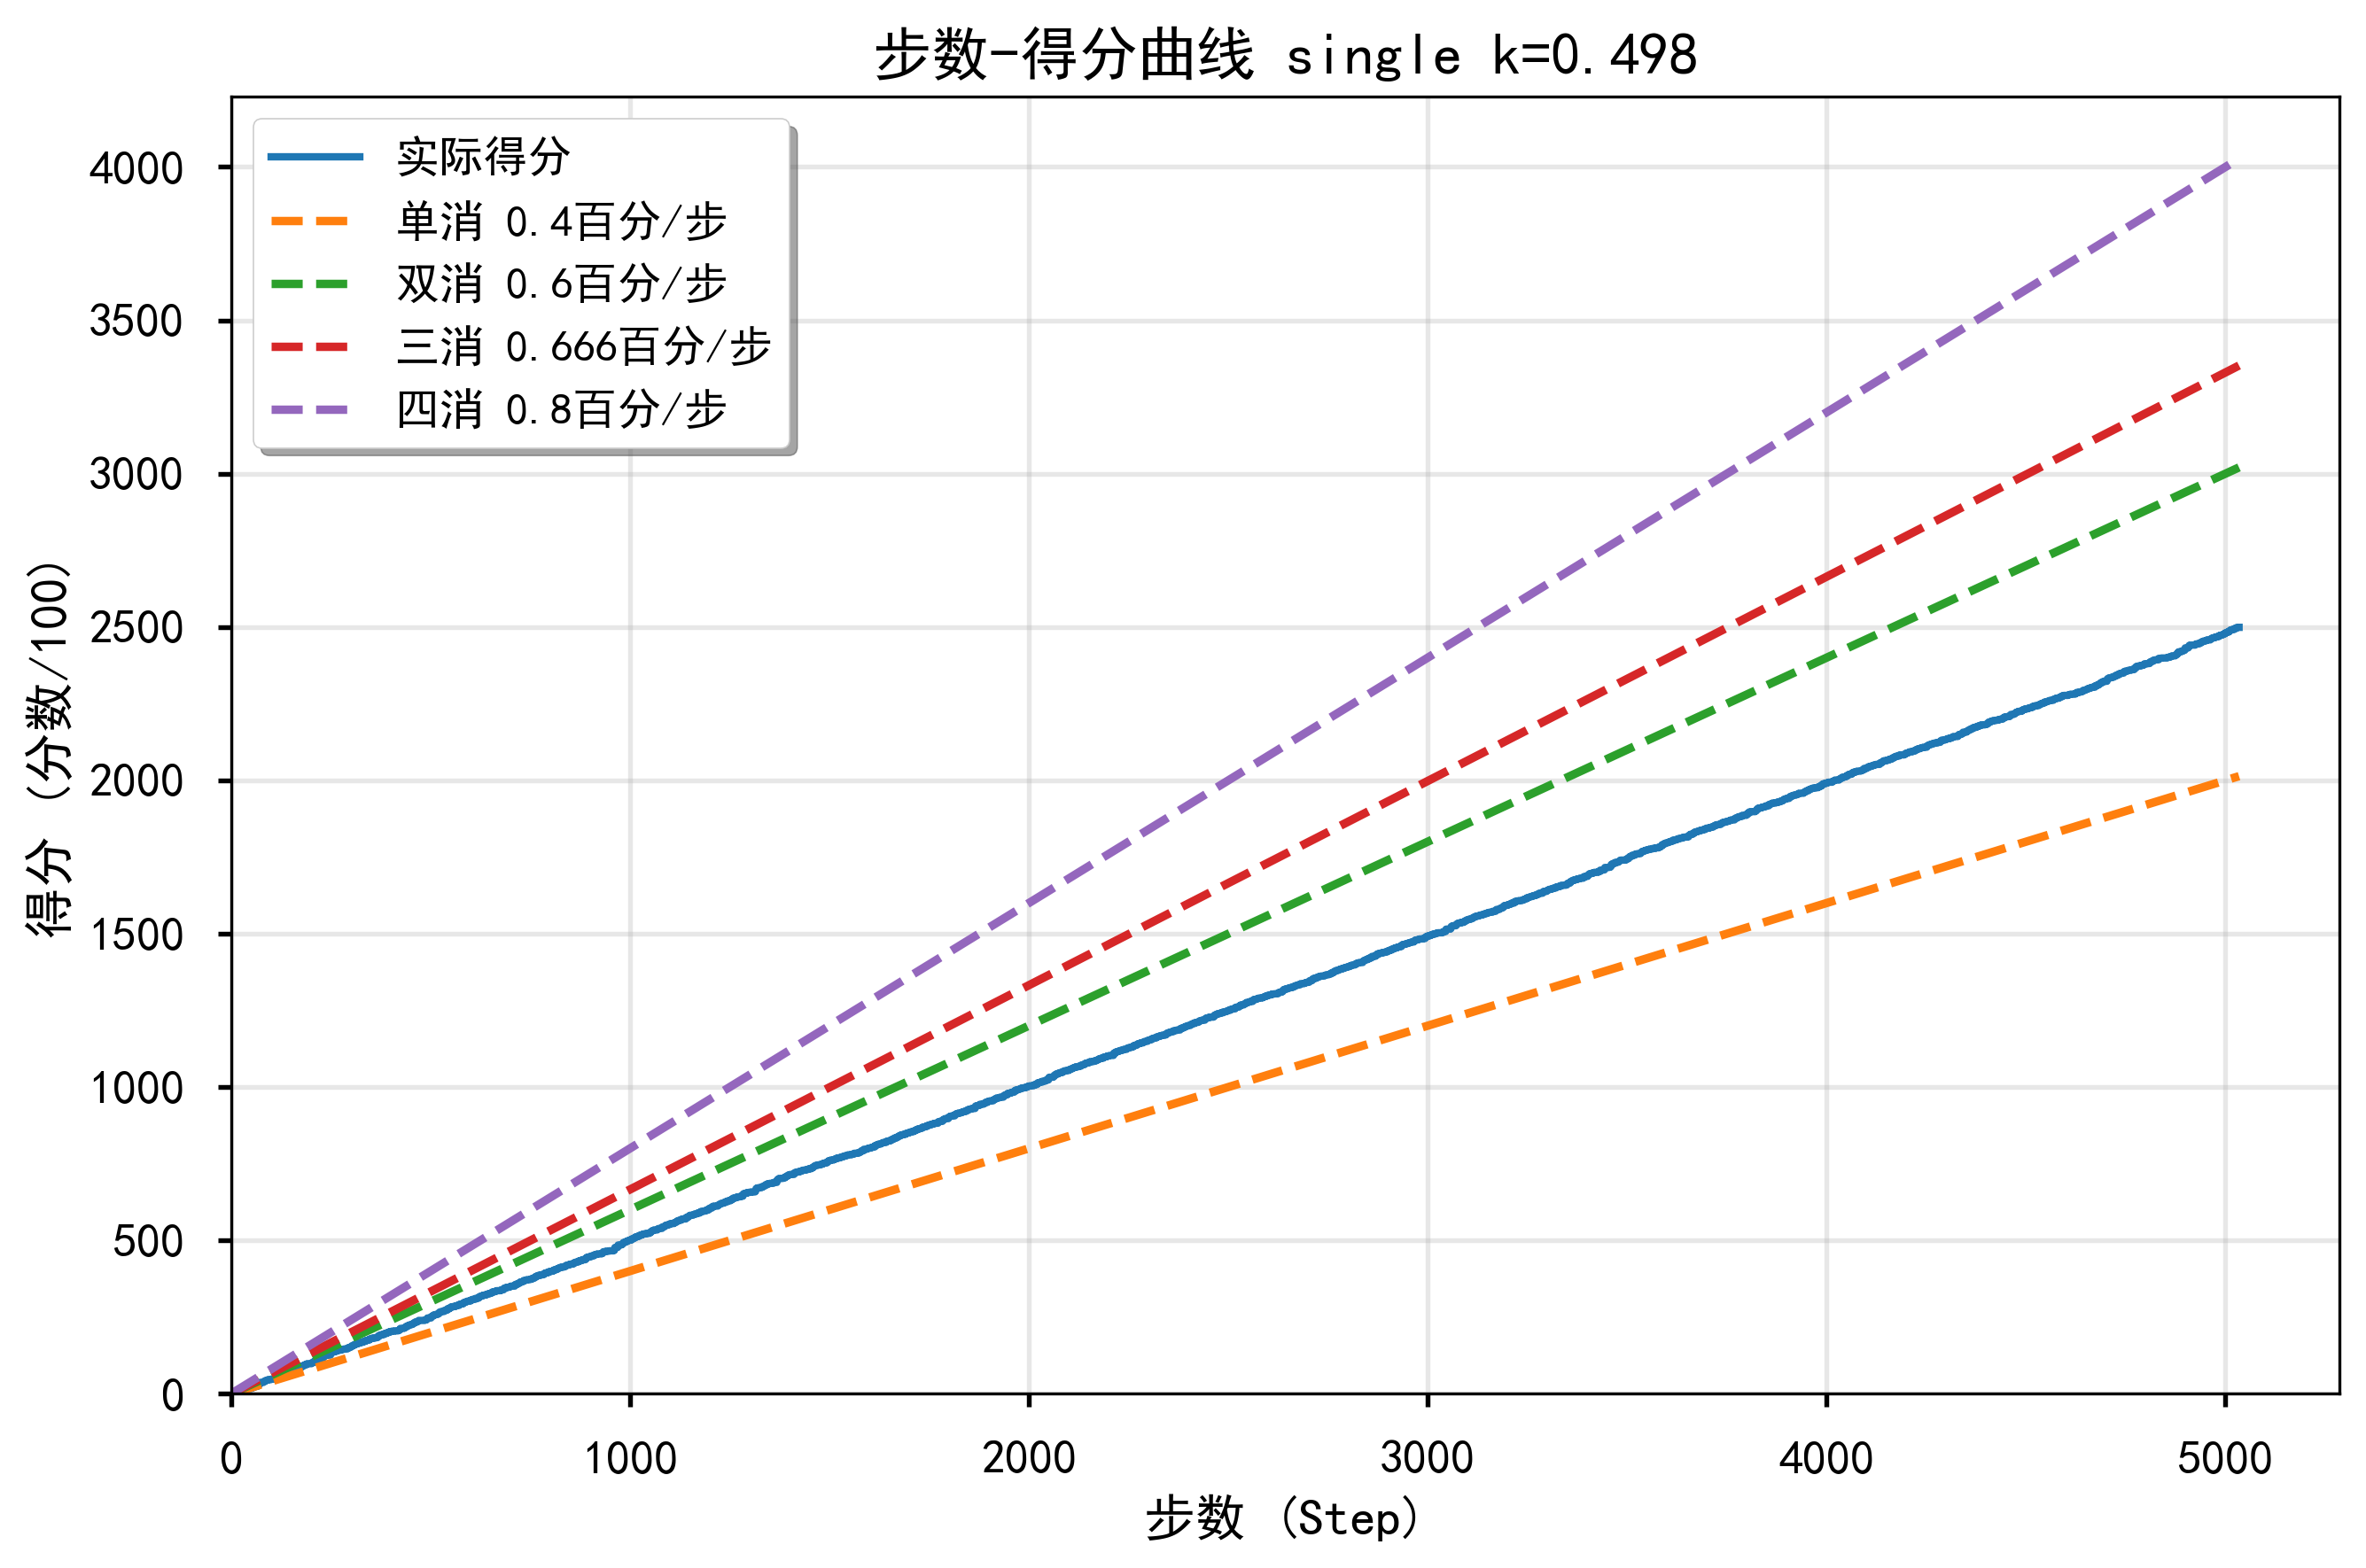

In [1]:
import re
import matplotlib.pyplot as plt
print(plt.style.available)
# 使用更美观的风格
plt.style.use('seaborn-v0_8-talk')
# 读取日志文件
with open('game.log', encoding='utf-8') as f:
    log = f.read()

# 正则提取 step 和 score
pattern = re.compile(r'step=(\d+)\s+score=(\d+)')
data = pattern.findall(log)

steps = [int(s) for s, _ in data]
steps = steps[:14600]
scores = [int(sc)/100 for _, sc in data]
scores = scores[:14600]

# 参考曲线
ref1 = [i * 0.4 for i in steps]
ref2 = [i * 0.6 for i in steps]
ref3 = [i * 0.666 for i in steps]
ref4 = [i * 0.8 for i in steps]

# 创建图表
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)
ax.plot(steps, scores, label='实际得分', linewidth=2)
ax.plot(steps, ref1, label='单消 0.4百分/步', linestyle='--')
ax.plot(steps, ref2, label='双消 0.6百分/步', linestyle='--')
ax.plot(steps, ref3, label='三消 0.666百分/步', linestyle='--')
ax.plot(steps, ref4, label='四消 0.8百分/步', linestyle='--')
k = sum(scores)/sum(steps)
# 设置中文字体（需本地安装）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 标题和标签
ax.set_title(f'步数-得分曲线 single k={k:.3f}', fontsize=16, fontweight='bold')
ax.set_xlabel('步数 (Step)', fontsize=14)
ax.set_ylabel('得分 (分数/100)', fontsize=14)

# 网格和图例
ax.grid(alpha=0.3)
ax.legend(frameon=True, fontsize=12, loc='best', shadow=True)
ax.set_xlim(0)
ax.set_ylim(0)
# 标注斜率

plt.tight_layout()
plt.show()



In [ ]:

from IPython.display import display_html
display_html(board_to_html(ai_game.board))
bug = ai_game.board

⬛⬛⬛⬛🟩⬛⬛⬛⬛⬛
⬛⬛⬛⬛🟩🟩⬛⬛⬛⬛
⬛⬛🟩🟩🟩⬛🟩🟩🟩🟩
⬛🟩🟩🟩🟩⬛⬛🟩🟩⬛
⬛🟩🟩🟩🟩⬛⬛🟩🟩⬛
⬛🟩🟩🟩🟩⬛🟩🟩🟩⬛
🟩🟩🟩🟩🟩🟩🟩🟩🟩⬛
🟩🟩🟩🟩🟩🟩🟩🟩🟩⬛
🟩🟩🟩🟩🟩🟩🟩🟩🟩⬛
⬛🟩🟩🟩🟩🟩🟩🟩🟩🟩
⬛🟩🟩🟩🟩🟩🟩🟩🟩🟩
🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩
🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩
🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩
🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩
⬛🟩🟩⬛🟩🟩🟩🟩🟩🟩
⬛🟩🟩🟩🟩🟩🟩🟩🟩🟩
⬛🟩🟩🟩🟩🟩🟩🟩🟩🟩
⬛🟩🟩🟩🟩🟩🟩🟩🟩🟩
⬛🟩🟩🟩🟩⬛🟩🟩🟩⬛

In [ ]:
print(subHoleCount(bug))
height = np.where((h := bug.argmax(axis=0)) != 0, 20 - h, 0)
print(height)
print(height.var())
%timeit subHoleCount(bug)
%timeit loss(bug)
%timeit conv2d(bug, kernel, padding=1, stride=1)

27
[14 17 18 18  0 19 18 18 18 18]
29.359999999999996
788 µs ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
112 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
35.2 µs ± 764 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# 新枚举函数测试

In [ ]:

from IPython.display import display_html
test = TetrisGame(seed=23)
states,boards = enumerate_GameStatus(ai_game)
for idx,i in enumerate(boards):
    display_html(board_to_html(i))
    print(states[idx])
    time.sleep(0.2)
    clear_output(wait=True)

⬛⬛🟩⬛🟩⬛⬛⬛⬛⬛
⬛🟩🟩⬛🟩🟩⬛⬛⬛⬛
⬛🟩🟩🟩🟩⬛🟩🟩🟩🟩
⬛🟩🟩🟩🟩⬛⬛🟩🟩⬛
⬛🟩🟩🟩🟩⬛⬛🟩🟩⬛
⬛🟩🟩🟩🟩⬛🟩🟩🟩⬛
🟩🟩🟩🟩🟩🟩🟩🟩🟩⬛
🟩🟩🟩🟩🟩🟩🟩🟩🟩⬛
🟩🟩🟩🟩🟩🟩🟩🟩🟩⬛
⬛🟩🟩🟩🟩🟩🟩🟩🟩🟩
⬛🟩🟩🟩🟩🟩🟩🟩🟩🟩
🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩
🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩
🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩
🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩
⬛🟩🟩⬛🟩🟩🟩🟩🟩🟩
⬛🟩🟩🟩🟩🟩🟩🟩🟩🟩
⬛🟩🟩🟩🟩🟩🟩🟩🟩🟩
⬛🟩🟩🟩🟩🟩🟩🟩🟩🟩
⬛🟩🟩🟩🟩⬛🟩🟩🟩⬛

[[0, 1], 1, 0]


In [ ]:
states

[[[0, 0], 0, 0],
 [[0, 1], 0, 0],
 [[0, 5], 0, 0],
 [[0, 6], 0, 0],
 [[0, 7], 0, 0],
 [[1, 0], 1, 0],
 [[0, 1], 1, 0]]

In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# 读取日志
with open('yc_final.log', encoding='GB2312') as f:
    log = f.read()

# 正则提取
pattern = re.compile(
    r'本代平均适应度: ([\d\.]+), 最佳适应度: ([\d\.]+).*?第 (\d+) 代完成，耗时: ([\d\.]+)秒',
    re.DOTALL
)
data = pattern.findall(log)

gens = []
avg_fit = []
best_fit = []
times = []

for avg, best, gen, t in data:
    gens.append(int(gen))
    avg_fit.append(float(avg))
    best_fit.append(float(best))
    times.append(float(t))

# 准备平滑曲线的数据
gens_np = np.array(gens)

# 定义更细的横坐标
gens_smooth = np.linspace(gens_np.min(), gens_np.max(), 500)

# 样条插值
def smooth_line(x, y):
    if len(x) < 4:
        return x, y  # 不够点数插值
    spl = make_interp_spline(x, y, k=3)
    return gens_smooth, spl(gens_smooth)

avg_smooth_x, avg_smooth_y = smooth_line(gens_np, np.array(avg_fit))
best_smooth_x, best_smooth_y = smooth_line(gens_np, np.array(best_fit))
time_smooth_x, time_smooth_y = smooth_line(gens_np, np.array(times))

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘图
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=120)

# 适应度曲线（平滑）
ax1.plot(avg_smooth_x, avg_smooth_y, label='平均适应度', color='tab:blue')
ax1.plot(best_smooth_x, best_smooth_y, label='最佳适应度', color='tab:orange')
ax1.set_xlabel('遗传迭代数')
ax1.set_ylabel('适应度')
ax1.legend(loc='upper left')
ax1.grid(True, axis='y', alpha=0.3)

# 耗时曲线（右轴，平滑）
ax2 = ax1.twinx()
ax2.plot(time_smooth_x, time_smooth_y, label='耗时(秒)', color='tab:red')
ax2.set_ylabel('耗时 (秒)')
ax2.legend(loc='upper right')

plt.title('遗传算法每代适应度与耗时（平滑曲线）')
plt.tight_layout()
plt.show()


ValueError: Expect x to be a 1D strictly increasing sequence.

In [ ]:
import timeit
def test_single_step():
    game = TetrisGame(seed=100)
    return game.step(4)
def base_create():
    game = TetrisGame(seed=100)
    return game
avg_time = timeit.timeit(test_single_step, number=1000) / 1000
avg_time -= timeit.timeit(base_create, number=1000) / 1000
print(f"单次step(4)平均耗时: {avg_time * 1000:.4f}毫秒")

单次step(4)平均耗时: 0.1156毫秒
